## Mini-Projeto - Agrupando Clientes Por Consumo de Energia

A partir de dados de consumo de energia de clientes, nosso trabalho é agrupar os consumidores por similaridade a afim de compreender o comportamento dos clientes e sua relação com o consumo de energia.

Vamos executar as seguintes tarefas:
    
1- Tratar os valores ausentes nos dados.

2- Coletar uma amostra de 1% dos dados para criar o modelo de clusterização com o K-Means.

3- Encontrar o melhor valor de K para esse conjunto de dados.

4- Criar o modelo K-Means usando o valor de K encontrado no item 3.

5- Criar um Meshgrid para visualização de todos os clusters.

6- Visualizar os centróides.

7- Calcular o Silhoutte Score.

8 - Calcular a média de consumo de energia por cluster (usar a coluna Global_active_power para o cálculo da média).

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Base de dados

https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [4]:
# Carregando os dados
dataset = pd.read_csv('household_power_consumption.txt', delimiter = ';', low_memory = False)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [7]:
dataset.shape

(97195, 9)

In [8]:
dataset.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

#### 1- Tratar os valores ausentes nos dados.

In [9]:
# Checando se há valores missing
dataset.isnull().values.any()

True

In [10]:
# Removendo os registros com valores NA e removendo as duas primeiras colunas (não são necessárias)
dataset = dataset.iloc[:, 2:9].dropna()

In [11]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [12]:
# Checando se há valores missing
dataset.isnull().values.any()

False

In [13]:
# Obtendo os valores dos atributos
dataset_atrib = dataset.values

In [14]:
dataset_atrib

array([['4.216', '0.418', '234.840', ..., '0.000', '1.000', 17.0],
       ['5.360', '0.436', '233.630', ..., '0.000', '1.000', 16.0],
       ['5.374', '0.498', '233.290', ..., '0.000', '2.000', 17.0],
       ...,
       ['2.356', '0.080', '239.280', ..., '0.000', '0.000', 0.0],
       ['2.364', '0.082', '239.710', ..., '0.000', '0.000', 0.0],
       ['2.362', '0.080', '239.660', ..., '0.000', '0.000', 0.0]],
      dtype=object)

#### 2- Coletar uma amostra de 1% dos dados para criar o modelo de clusterização com o K-Means.

In [15]:
# Coletando uma amostra de 1% dos dados para criação do modelo Kmeans
amostra1, amostra2 = train_test_split(dataset_atrib, train_size = .01)

In [16]:
amostra1.shape

(971, 7)

In [17]:
amostra2.shape

(96217, 7)

In [18]:
# Aplicando redução de dimensionalidade
pca = PCA(n_components = 2).fit_transform(amostra1)

In [19]:
pca.shape

(971, 2)

In [20]:
pca

array([[-5.55403545,  2.93413086],
       [-9.05776352,  1.4681703 ],
       [-9.58574261,  0.56024499],
       ...,
       [-9.78592763,  0.47052163],
       [-4.74808216,  3.34621661],
       [ 7.18824501, -6.2115831 ]])

#### 3- Encontrar o melhor valor de K para esse conjunto de dados.

Documentação Scipy Spacial Distance

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

In [21]:
# Determinando um range de K
k_range = range(1,12)

In [22]:
# Aplicando um modelo K-Means para cada valor de k
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

In [23]:
# Ajustando o centroide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

In [24]:
# Calculando a distancia euclidiana de cada ponto de dado para o centroide
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

In [25]:
# Soma dos quadrados da distancia dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

In [26]:
# Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]

In [27]:
# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

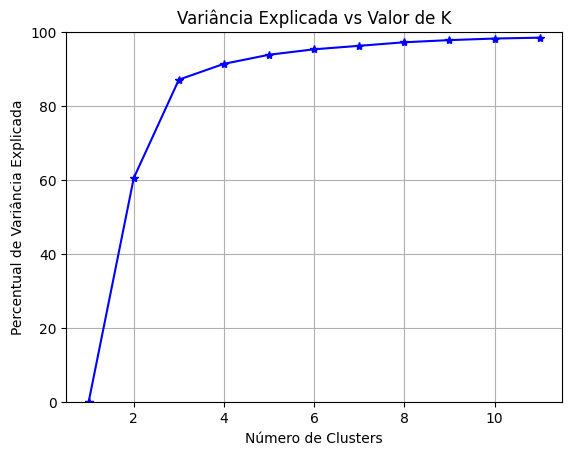

In [28]:
# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Percentual de Variância Explicada')
plt.title('Variância Explicada vs Valor de K')
plt.show();

A partir de 8 clusters eu consigo explicar um percentual de variância maior nos dados.

4- Criar o modelo K-Means

In [29]:
# Criando um modelo com k = 8
modelo_v1 = KMeans(n_clusters = 8)
modelo_v1.fit(pca)

KMeans()

#### 5- Criar um Meshgrid para visualização de todos os clusters.

In [30]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

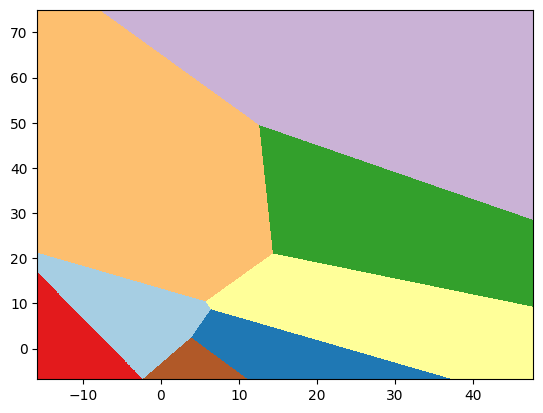

In [31]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z,
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto',
           origin = 'lower')

#### 6- Visualizar os centróides.

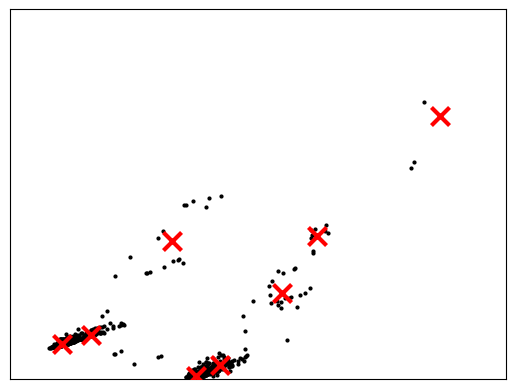

In [32]:
# Plot dos centróides
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v1.cluster_centers_
inert = modelo_v1.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

#### 7- Calcular o Silhoutte Score.

In [33]:
?silhouette_score

In [34]:
# Silhouette Score
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.6218595418537947

In [35]:
# Criando um modelo com K = 10
modelo_v2 = KMeans(n_clusters = 10)
modelo_v2.fit(pca)

KMeans(n_clusters=10)

In [36]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

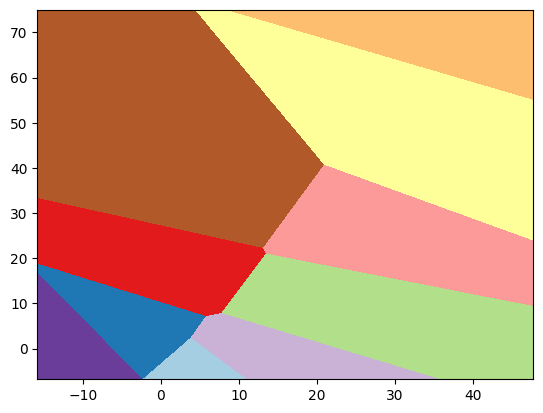

In [37]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z,
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto',
           origin = 'lower')

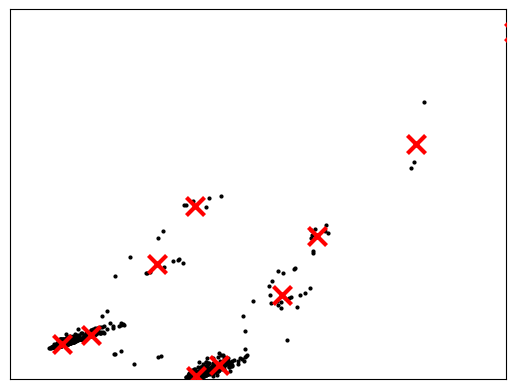

In [38]:
# Plot dos centróides
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v2.cluster_centers_
inert = modelo_v2.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [39]:
# Silhouette Score
labels = modelo_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.6227971991261929

Criando o Cluster Map com os clusters do Modelo V1 que apresentou melhor Silhouette Score.

In [40]:
# Lista com nomes das colunas
names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [41]:
# Cria o cluster map
cluster_map = pd.DataFrame(amostra1, columns = names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = modelo_v1.labels_

In [42]:
cluster_map

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,2.434,0.156,242.510,10.000,0.000,0.000,0.0,0
1,0.400,0.316,243.650,2.000,0.000,1.000,0.0,3
2,0.302,0.068,243.570,1.400,0.000,0.000,0.0,3
3,3.696,0.244,239.600,15.600,0.000,0.000,18.0,1
4,1.564,0.244,237.620,6.600,0.000,1.000,18.0,7
...,...,...,...,...,...,...,...,...
966,0.290,0.000,242.250,1.200,0.000,0.000,0.0,3
967,2.756,0.000,237.990,12.400,23.000,0.000,17.0,1
968,0.294,0.100,244.200,1.200,0.000,0.000,0.0,3
969,2.712,0.126,241.020,11.200,0.000,0.000,0.0,0


#### 8 - Calcular a média de consumo de energia por cluster (usar a coluna Global_active_power para o cálculo da média).

In [43]:
# Calcula a média de consumo de energia por cluster
cluster_map.groupby('cluster')['Global_active_power'].mean()

cluster
0    2.118784
1    3.087277
2    4.456833
3    0.433691
4    3.306111
5    7.505000
6    3.914952
7    1.698069
Name: Global_active_power, dtype: float64